# Statistics fundamentals
This section will cover a few of the basics in statistical analysis. It'll try to take a practical / intuitive approach over a complete approach.

## Packages we'll use
* Matplotlib - for visualizing data / distributions, which makes things easier to conceptualize.
* statsmodels - for doing statistical modeling of the more rigorous kind.
* Pandas / Numpy - for data munging etc
* scikit-learn - for a little taste of machine learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as stt
import statsmodels.api as sm
from ipywidgets import interact, IntSlider
from tqdm import tqdm
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Samples vs. populations
It may sound pedantic, but it's really important to remember that the foundation of statistics rests on differentiating a **sample** from a **population**.

In science we almost **always** collect samples, via experiments or fieldwork. As such, the big question we must answer is:

**Are the properties of our sample reflective of the overall population, or simply due to noise?**

For example, let's consider the random distribution below. It will be a "population". Maybe it represents something like average difference in rainfall between Berkeley and San Francisco.

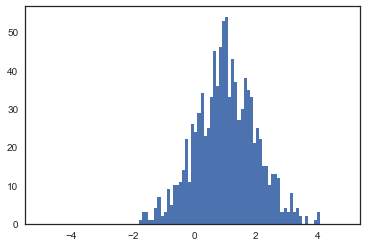

In [2]:
# Generate a random population of values
mean_population = 1
population = np.random.randn(1000) + mean_population

fig, ax = plt.subplots()
bins = np.arange(-5, 5, .1)
ax.hist(population, bins=bins);  # The semicolon just prevents the output from this line from displaying

Via some experiment, we collect a random sample from this population:

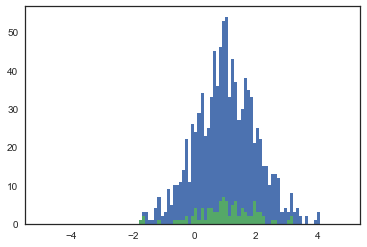

In [3]:
# Simulate taking a random sample from this population
sample_size = 100
sample = np.random.choice(population, size=sample_size)

fig, ax = plt.subplots()
ax.hist(population, bins)
ax.hist(sample, bins);

Remember that in reality, we don't actually have the population itself, so we really only see this:

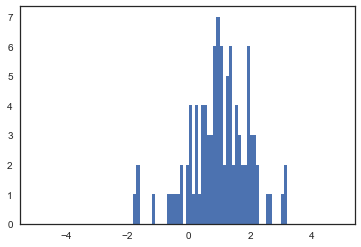

In [4]:
fig, ax = plt.subplots()
ax.hist(sample, bins=bins);

In this case, we have two measures of interest:

1. What is the statistic that we care about (e.g., the mean)?
1. What is the variability of that statistic?

And then:

1. Given these two things, can we conclude that the statistic we've calculated deviates from some null value?

**All of statistics is basically a process of answering these questions.**

# Hypothesis testing - Parametric tests

So we are faced with the problem that we don't know the population, we have a sample, and we want to generalize our sample to the full population.

The easiest way to do this is to make assumptions about our sample. One way to do this is to describe it with some mathematical distribution that is defined by **parameters**.

## The t-distribution
The most common version of this is the t-distribution, which is kind of like a normal distribution, except its tails grow larger when you have a smaller sample size. It has 3 parameters:

1. The mean
2. The standard deviation
3. The degrees of freedom (aka roughly the # datapoints)

In [5]:
# Let's see how this changes with different degrees of freedom
def plot_t(df=1):
    fig, ax = plt.subplots()
    # Plot the t-dist
    ax.plot(bins, stt.t.pdf(bins, df, loc=mean_population, scale=1), label='t')
    
    # Plot a normal distribution
    ax.plot(bins, stt.norm.pdf(bins, loc=mean_population, scale=1), label='normal')
    
    # Show the fig
    ax.set(ylim=[0, .5])
    plt.legend()
    plt.show()
interact(plot_t, df=IntSlider(1, 1, 20, 1));

A Jupyter Widget

We can use the t-distribution to model the dataset that we've got.

In [6]:
# Calculate the statistics we can use to define a t-distribution
data_mean = sample.mean()
data_std = sample.std()
data_df = sample.shape[0] - 1

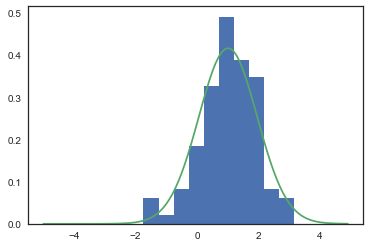

In [7]:
# Fit a t-distribution to our data
t_dist = stt.t.pdf(bins, data_df, data_mean, data_std)

# Visualize it on our sample
fig, ax = plt.subplots()
ax.hist(sample, normed=True)
ax.plot(bins, t_dist)

## t-tests

A t-test is a bit different from the t-distribution we showed above. Instead of fitting a distribution to our sample, we try to *use* the sample in order to infer a **null distribution**.

The point of this test is to ask "is the data we collected different from this null distribution?"

Remember our point from before: **always think in terms of the statistical comparison you want to make.** In this case, we care about a difference in means between these two groups.

This means that we'll actually estimate the **standard error** rather than the standard deviation, reflecting the fact that we care about the "mean" of the data, rather than the data itself.

The difference is that rather than modeling the data, we'll assume a **null** distribution using the data as a guide.

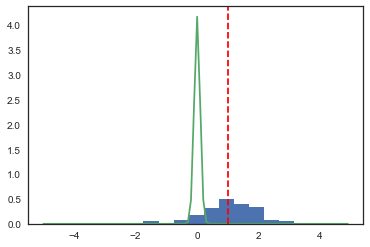

In [8]:
# Calculate the standard error
data_ste = data_std / np.sqrt(len(sample))

# Fit a t-distribution to our data
t_dist = stt.t(data_df, 0, data_ste)
t_pdf = t_dist.pdf(bins)

# Visualize it on our sample
fig, ax = plt.subplots()
ax.hist(sample, normed=True)
ax.plot(bins, t_pdf)
ax.axvline(sample.mean(), c='r', ls='--')

The question we'd then ask is: "is the blue distribution significantly different from the green distribution?"

To do this, we'd calculate the percentile of the mean of the blue distribution with respect to the orange distribution:

In [9]:
percentile_sample = t_dist.cdf(np.mean(sample))
p_value = 1 - percentile_sample
print(p_value)

0.0


We can also easily perform this test using a scipy function:

In [10]:
stt.ttest_1samp(sample, 0)

Ttest_1sampResult(statistic=10.452283311194734, pvalue=1.1304556921240095e-17)

## Why do we care about p < .05?

Essentially, because we need a "decision point" to decide whether or not to believe a statistic. This is inherently arbitrary, but it's a reasonable enough number to use for the last hundred or so years.

Essentially, the `p < .05` rule says that:

    I will only accept these results as "significant" if their probability under the null hypothesis was < 5%


**The problem with this**: It means that rougly 5% of the time, you'll be totally wrong.

For example, below we'll repeat the process of taking a random sample from the population.

On each iteration, we'll calculate a ttest for the difference from the population mean.

In [11]:
# Define our iteration parameters
n_iterations = 10000
sample_size = 100

# Now simulate a bunch of random samples from the population
pvalues = []
for ii in tqdm(range(n_iterations)):
    sample = np.random.choice(population, size=sample_size)
    pvalues.append(stt.ttest_1samp(sample, mean_population).pvalue)
pvalues = np.array(pvalues)

100%|██████████| 10000/10000 [00:04<00:00, 2070.30it/s]


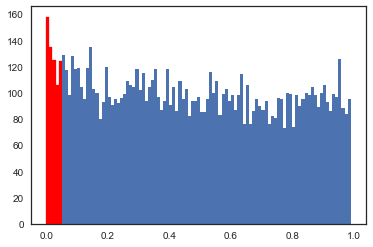

In [12]:
# Plot the number of samples that are < .05
fig, ax = plt.subplots()
_, _, patches = ax.hist(pvalues, bins=np.arange(0, 1, .01))
for p in patches:
    if p.xy[0] < .05:
        p.set_color('r')

## A side-note on multiple comparisons

As we showed above - if you're using p < .05 as a marker of "significance", it means you'll get a False Positive roughly 5% of the time. This is an even bigger problem when you're running lots of tests for significance.

In this case, we've done a bunch of statistical tests, and we've found a few that are significant!

BUT - we've made a *ton* of comparisons. We need to correct for this. There are many ways to do this, but here are two quick ones:

In [13]:
# We had this many originally-accepted p-values
print(sum(pvalues < .05))

648


Bonferroni correction simply divides the cutoff p-value amount by the number of comparisons


In [14]:
accepted, pvals_corrected, _, _ = sm.stats.multipletests(
    pvalues, method='bonferroni')
sum(accepted)

0

The False Discovery Rate is smarter about how it chooses a cutoff. 
It attempts to minimize the ratio of "false positives" to "true positives".

It is **more powerful** in the sense that you're more likely to find a positive result with this.

In [15]:
# The False Discovery Rate is smarter about how it chooses a cutoff. 
# It attempts to minimize the ratio of "false positives" to "true positives"
# It is
accepted, pvals_corrected, _, _ = sm.stats.multipletests(
    pvalues, method='fdr_bh')
sum(accepted)

0

# Generalizing to two groups - now with our data

We'll load in our data so that we can start to make some actual comparisons between variables.

Let's ask whether the life expectancy was different between USA and Canada:

In [16]:
# Load the data
country_data = pd.read_csv('../projects/gapminder/data/02_cleaned/country_data_clean.csv')
gapminder_data = pd.read_csv('../projects/gapminder/data/02_cleaned/gapminder_clean.csv')
data = pd.merge(country_data, gapminder_data, on='country')

In [17]:
# Pull only two continents, and one year's worth of data
continent_1 = 'asia'
continent_2 = 'americas'

data_continent = data.query('continent in [@continent_1, @continent_2] and year == 1952')
data_continent = data_continent.set_index('continent')['life_exp']

We can easily calculate a t-test for the *difference* between two groups:

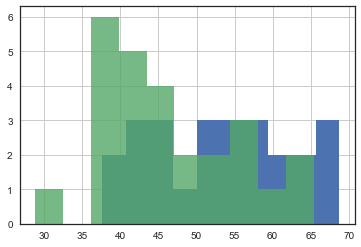

In [18]:
data_continent[continent_2].hist()
data_continent[continent_1].hist(alpha=.8)

In [19]:
# Calculate a t-test between these two groups
result = stt.ttest_ind(data_continent[continent_1], data_continent[continent_2])
result

Ttest_indResult(statistic=-2.7663938871382028, pvalue=0.007972057037790475)

Essentially, this is doing the same thing as the 1-sample t-test we covered above.

It is calculating the mean of each group, then the difference between them, then assuming they each follow a t-distribution.

However, if you look at the distributions above, you'll see that the really don't follow a clean "normal" distribution. This is an assumption of t-tests, so what can we do to improve this

## Permutation tests

Permutation tests are basically a way of brute-force generating our null distribution. It's a way to explicitly define your definition of "no difference", and it's also more sensitive to the particular distribution of your actual data. Here's how it works:

* Define the conditions that would constitute a "null" effect (e.g., no difference between groups)
* Figure out how to create these conditions (e.g., randomly permute group labels)
* Calculate the statistic of interest for this null set (e.g., difference in group means)
* Repeat this many, many times
* See where our experimental statistic falls on this distribution

We'll perform a permutation test below:

In [20]:
# First calculate the "true" difference between our groups
data_difference = data_continent[continent_1].mean() - data_continent[continent_2].mean()

In [21]:
# Now run the permutation test
n_permutations = 5000
perm_means = np.zeros(n_permutations)
for ii in tqdm(range(n_permutations)):
    # Define random indices for our data
    random_indices = np.random.permutation(range(len(data_continent)))
    
    # Copy, then shuffle the labels of our data
    permutation_data = data_continent.copy()
    permutation_data.index = permutation_data.index[random_indices]
    
    # Now calculate our stat of interest
    stat = permutation_data[continent_1].mean() - permutation_data[continent_2].mean()
    perm_means[ii] = stat

100%|██████████| 5000/5000 [00:04<00:00, 1012.09it/s]


Below, we'll plot the distribution of the randomly acquired differences, where we have forced there to be *no difference* between the two groups. We'll also show the "true" or "empirical" difference between the groups.

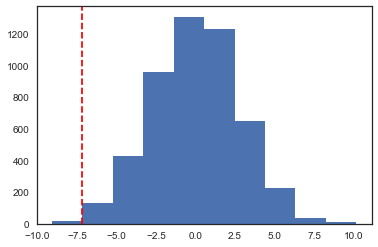

In [22]:
fig, ax = plt.subplots()
ax.hist(perm_means)
ax.axvline(data_difference, c='r', ls='--')

The permutation test works by basically asking the same question as a t-test:

    How likely is the empirical mean, given our permutation null distribution?

To answer this, we can build what is called an "empirical" distribution:

In [23]:
perm_distribution = sm.distributions.ECDF(perm_means)
perm_distribution(data_difference)

0.0036000000000000003

# Confidence intervals

While significance testing is still extremely common, it's becoming more popular to estimate the variability of your statistic directly, rather than using something like a p-value. One of doing this is to build a confidence interval.

These are quite similar to permutation tests, except that instead of generating a p-value, they directly measure the variability in the statistic of interest.

They have the benefits of:

1. Being in the same units as your data (or whatever test statistic you care about)
1. Giving an idea for the variability of the data itself
1. Are less-subject to "hacking" for the sake of significance.

## The bootstrap
A common way to generate confidence intervals is to use the **bootstrap method**. This means the following steps:

1. Take a random sample of each group in your data **with replacement** (take a sample as large as the number of datapoints in each group)
1. Calculate the statistic of interest
1. Repeat this many times to generate a distribution of these statistics
1. Calculate the percentiles of this distribution for your confidence interval

In [24]:
# Pull two groups out of our data
group_a = data_continent[continent_1]
group_b = data_continent[continent_2]

In [25]:
# Permorn the bootstrap resampling
n_bootstraps = 5000
boot_diffs = np.zeros(n_bootstraps)
for ii in tqdm(range(n_bootstraps)):
    # Define random indices for our data
    ixs_a = np.random.randint(0, len(group_a), len(group_a))
    ixs_b = np.random.randint(0, len(group_b), len(group_b))
    
    # Take a random sample from each group
    boot_a = group_a[ixs_a]
    boot_b = group_b[ixs_b]
    
    # Now calculate the difference in means of each group
    diff = boot_a.mean() - boot_b.mean()
    boot_diffs[ii] = diff


100%|██████████| 5000/5000 [00:06<00:00, 738.50it/s]


Now, we can visualize the distribution of bootstrapped differences. Note that this distribution is **not** the same thing as a permutation distribution, which simulated the **null** distribution.

In this case, this distribution represents the variability in the statistic we care about (in this case, the mean difference between groups)

(array([   45.,   212.,   669.,  1198.,  1385.,   946.,   405.,   119.,
           18.,     3.]),
 array([-14.91908154, -13.10276446, -11.28644738,  -9.47013031,
         -7.65381323,  -5.83749615,  -4.02117908,  -2.204862  ,
         -0.38854492,   1.42777215,   3.24408923]),
 <a list of 10 Patch objects>)

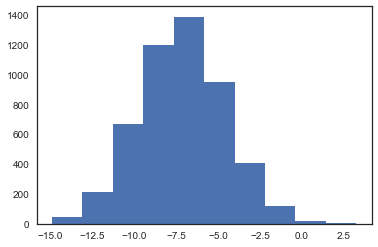

In [26]:
fig, ax = plt.subplots()
ax.hist(boot_diffs)

From this distribution, we can calculate the 95% confidence interval. This corresponds to the 2.5th and 97.5th percentile of this data.

In [27]:
# Calculate the confidence interval
lo, hi = np.percentile(boot_diffs, [2.5, 97.5])
print(lo, hi)

-12.0780003462 -2.07030930769


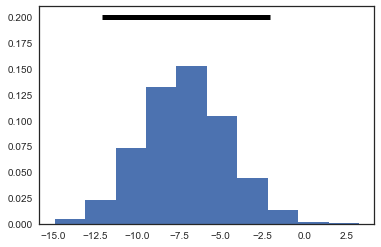

In [28]:
# Now plot the confidence interval with the distribution
fig, ax = plt.subplots()
ax.hist(boot_diffs, normed=True)
ax.hlines(.2, lo, hi, linewidth=5)

A good rule of thumb is that if a 95% confidence interval does *not* overlap with zero, then p would also be <.05

## What does a confidence interval mean anyway?
Many people interpret the 95% as meaning "there is a 95% chance that the statistic is within this range". **This is wrong**.

* Most wrongly: it gives the impression that the statistic is "more likely" to be in the center of the confidence interval. This isn't true.

A confidence interval means that when the process above is performed (including the experiment and sample collection), there is a 95% chance that the interval will contain the "true" mean.

For example, below we'll repeat the entire process for a random distribution. The question we'll ask is simply "is the random sample significantly different from 0?".

We'll take a random sample, then calculate a bootstrapped confidence interval around the mean difference between groups. We'll repeat this many times and see how often we get a "hit"

In [29]:
n_experiments = 200
n_bootstraps = 500

means = np.zeros([n_experiments, n_bootstraps])
for i_exp in tqdm(range(n_experiments)):
    # Simulate taking a random sample from the population
    sample = np.random.choice(population, 100)
    for i_boot in range(n_bootstraps):
        # Define the bootstrap indices
        ixs = np.random.randint(0, len(sample), len(sample))
        
        # Take the random sample
        boot_sample = sample[ixs]
        
        # Calculate the difference
        means[i_exp, i_boot] = np.mean(boot_sample)
        
# Calculate the 95% confidence interval for each iteration
percentiles = np.percentile(means, [2.5, 97.5], axis=1)

100%|██████████| 200/200 [00:02<00:00, 76.55it/s]


Remember, the "true" population has a mean of 1:

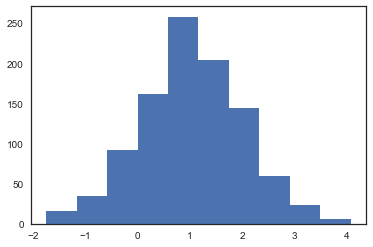

In [30]:
fig, ax = plt.subplots()
ax.hist(population);

Below we'll plot the confidence interval of each iteration. Note how many of them **don't** overlap with the "true" population mean:

[Text(0.5,1,'10% of intervals do not overlap w/ mean')]

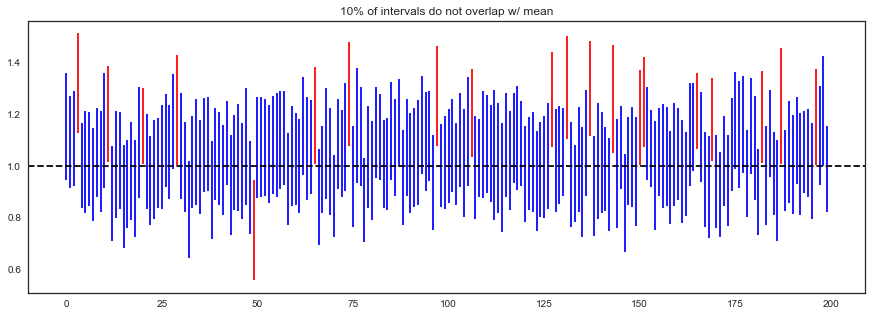

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
n_outside = 0
for ii, (lo, hi) in enumerate(percentiles.T):
    if (mean_population < lo) or (mean_population > hi):
        n_outside += 1
        color = 'r'
    else:
        color = 'b'
    ax.vlines(ii, lo, hi, color=color)
ax.axhline(mean_population, ls='--', c='k')
ax.set(title='{}% of intervals do not overlap w/ mean'.format(int(n_outside / n_experiments * 100)))

## Repeated measures comparisons

The third most common kind of statistical comparison is just a generalization of the two-sample test. A repeated measures test simply means that some of the datapoints have known dependencies between one another.

For example, if we collect data from the same subject multiple times.

**This means you can increase the power of the test**. Essentially, it allows you to use the within-subject variability as the variability you put into your test, which is almost always smaller.

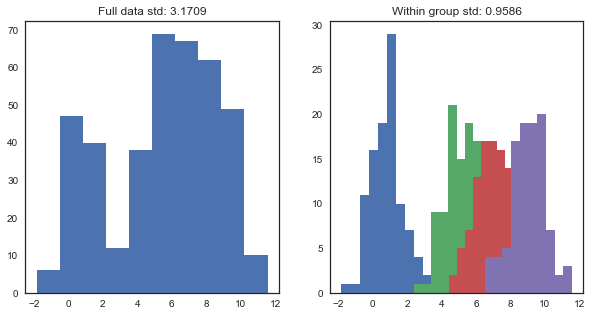

In [32]:
group_means = [1, 5, 7, 9]
groups = np.random.randn(100, 4) + group_means

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axs[0].hist(groups.ravel())
axs[0].set(title='Full data std: {:.4f}'.format(groups.ravel().std()))

for group in groups.T:
    std_within = groups.std(0).mean()
    axs[1].hist(group)
    axs[1].set(title='Within group std: {:.4f}'.format(std_within))

Let's see how this looks on our data. We'll include the "year" variable in our inter-continental comparison. This means we'll have many values collected over time from the same group.

In [33]:
# Get our data ready for the test
data_continent_by_year = data.query('continent in [@continent_1, @continent_2]')
data_continent_by_year = data_continent_by_year.groupby(['year', 'continent']).mean()['gdppercap']
data_continent_by_year_tidy = data_continent_by_year.reset_index()
data_continent_by_year = data_continent_by_year.unstack('continent')

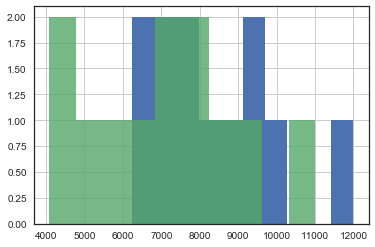

In [34]:
# Here's what the two groups look like
data_cont_1 = data_continent_by_year[continent_1]
data_cont_2 = data_continent_by_year[continent_2]

fig, ax = plt.subplots()
data_cont_1.hist()
data_cont_2.hist(alpha=.8)

When we make a comparison, it looks like there isn't a difference between them:

In [35]:
stt.ttest_ind(data_cont_1, data_cont_2)

Ttest_indResult(statistic=1.620113554644925, pvalue=0.11945479907854753)

However, a factorplot can be a useful way to visualize these kinds of trends. If we add color, we can see that there's a consistent difference between the two each year.

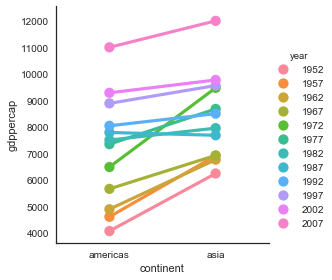

In [36]:
sns.factorplot('continent', 'gdppercap', data=data_continent_by_year_tidy, hue='year')

So, we'll subtract these two groups **first**. The result will be one distribution for the difference between the groups within each year.

In [37]:
diffs = data_cont_1 - data_cont_2
diffs.head()

year
1952    2168.722952
1957    2300.018685
1962    1867.037084
1967    1261.476270
1972    2982.514345
dtype: float64

Now, we can run a simple 1-sample t-test for a difference:

In [38]:
stt.ttest_1samp(diffs, 0)

Ttest_1sampResult(statistic=4.6348597378050043, pvalue=0.00072266590472619993)

# Linear models

Finally, we'd be remiss not to cover a statistical concept that has been underlying everything we've done so far: the linear model.

Linear models are perhaps most often used to correlate two continuous variables.

Below, we'll look at how the type of government, murder rate, and life expectancy are all related.

In [39]:
# Add the log murder rate to our data for use later
data['log_murder_rate'] = np.log(data['murder_rate'])

# We'll average across years to keep this more manageable
keep_descriptions = ['republic', 'parliamentary democr', 'constitutional monar']
data_avg = data.groupby(['country', 'continent', 'description']).mean().reset_index()
data_avg = data_avg.query('description in @keep_descriptions')

Linear modeling essentially just means fitting a line to some data. This is also known as *regression*. Remember this is easy to visualize in seaborn:

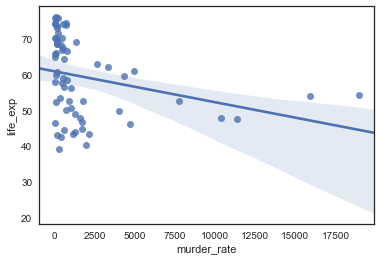

In [40]:
sns.regplot('murder_rate', 'life_exp', data=data_avg)

How do we know whether this linear relationship is significant?

statsmodels has an excellent collection of linear modeling features. It has a syntax similar to that of `R`. This follows this form:

```
y ~ x1 + x2
```

The above form means "model the variable 'y' with the variables 'x1' and 'x2'"

In [41]:
# We call this linear model with the following lines:
lm = sm.formula.ols('life_exp ~ murder_rate', data=data_avg).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.065   
Dependent Variable: life_exp         AIC:                493.8990
Date:               2017-05-07 10:42 BIC:                498.2478
No. Observations:   65               Log-Likelihood:     -244.95 
Df Model:           1                F-statistic:        5.441   
Df Residuals:       63               Prob (F-statistic): 0.0229  
R-squared:          0.080            Scale:              113.33  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept     60.8506    1.4839  41.0069  0.0000  57.8852  63.8159
murder_rate   -0.0009    0.0004  -2.3327  0.0229  -0.0016  -0.0001
-----------------------------------------------------------------
Omnibus:               14.374       Durbin-Watson:          1.827
Prob(Omnibus):         0.001        Jarque-Bera (JB):       4.526
Skew:                  -0.314       Prob(JB):               0.104
Kurtosis:              1.870        Condition No.:          4504 
=================================================================
* The condition number is large (5e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

However, remember that linear modeling is best-done with roughly symmetric and non-skewed data

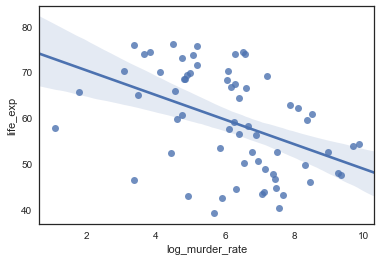

In [42]:
sns.regplot('log_murder_rate', 'life_exp', data=data_avg)

In [43]:
lm = sm.formula.ols('life_exp ~ log_murder_rate', data=data_avg).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.189   
Dependent Variable: life_exp         AIC:                484.6806
Date:               2017-05-07 10:42 BIC:                489.0294
No. Observations:   65               Log-Likelihood:     -240.34 
Df Model:           1                F-statistic:        15.87   
Df Residuals:       63               Prob (F-statistic): 0.000179
R-squared:          0.201            Scale:              98.343  
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         75.7642   4.3190 17.5421 0.0000 67.1333 84.3950
log_murder_rate   -2.6875   0.6746 -3.9837 0.0002 -4.0356 -1.3394
-----------------------------------------------------------------
Omnibus:               5.537        Durbin-Watson:          1.981
Prob(Omnibus):         0.063        Jarque-Bera (JB):       3.360
Skew:                  -0.366       Prob(JB):               0.186
Kurtosis:              2.161        Condition No.:          23   
=================================================================

"""

We can also fit a linear model with a *categorical* input variable. In this case, the continent:

In [44]:
lm = sm.formula.ols('life_exp ~ continent', data=data_avg).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.715   
Dependent Variable:   life_exp          AIC:                 419.6086
Date:                 2017-05-07 10:42  BIC:                 430.4805
No. Observations:     65                Log-Likelihood:      -204.80 
Df Model:             4                 F-statistic:         41.04   
Df Residuals:         60                Prob (F-statistic):  1.54e-16
R-squared:            0.732             Scale:               34.599  
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             49.5873   1.1116 44.6082 0.0000 47.3637 51.8108
continent[T.americas] 11.2613   2.3581  4.7756 0.0000  6.5444 15.9782
continent[T.asia]     12.1971   2.0931  5.8273 0.0000  8.0103 16.3840
continent[T.europe]   22.3992   1.8086 12.3850 0.0000 18.7815 26.0169
continent[T.oceania]  24.4022   5.9862  4.0764 0.0001 12.4280 36.3765
---------------------------------------------------------------------
Omnibus:                0.757         Durbin-Watson:            1.922
Prob(Omnibus):          0.685         Jarque-Bera (JB):         0.651
Skew:                   0.239         Prob(JB):                 0.722
Kurtosis:               2.893         Condition No.:            9    
=====================================================================

"""

If we have multiple variables, we only need to add them with a `+` symbol:

In [45]:
lm = sm.formula.ols('life_exp ~ continent + description', data=data_avg).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                    OLS                    Adj. R-squared:           0.728   
Dependent Variable:       life_exp               AIC:                      418.1702
Date:                     2017-05-07 10:42       BIC:                      433.3909
No. Observations:         65                     Log-Likelihood:           -202.09 
Df Model:                 6                      F-statistic:              29.60   
Df Residuals:             58                     Prob (F-statistic):       5.99e-16
R-squared:                0.754                  Scale:                    32.920  
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                           54.2712   2.4277 22.3553 0.0000 49.4117 59.1307
continent[T.americas]               11.3044   2.3030  4.9086 0.0000  6.6945 15.9143
continent[T.asia]                   10.0266   2.2659  4.4249 0.0000  5.4908 14.5623
continent[T.europe]                 20.5247   1.9684 10.4272 0.0000 16.5846 24.4649
continent[T.oceania]                22.2045   6.1480  3.6116 0.0006  9.8979 34.5112
description[T.parliamentary democr] -2.4862   2.5310 -0.9823 0.3300 -7.5526  2.5801
description[T.republic]             -5.0471   2.3009 -2.1935 0.0323 -9.6529 -0.4414
-----------------------------------------------------------------------------------
Omnibus:                    0.877              Durbin-Watson:                 1.778
Prob(Omnibus):              0.645              Jarque-Bera (JB):              0.770
Skew:                       0.260              Prob(JB):                      0.681
Kurtosis:                   2.882              Condition No.:                 11   
===================================================================================

"""

Finally, we can include **interaction terms** by using a `*`. This attempts to find the relationship between variables, as well as their independent effects on the output.

In [46]:
lm = sm.formula.ols('life_exp ~ continent * description', data=data_avg).fit()
lm.summary2()

/Users/choldgraf/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1263: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/choldgraf/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/choldgraf/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/choldgraf/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/choldgraf/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Ordinary least squares
==========================================================================================================
Model:                             OLS                           Adj. R-squared:                  0.739   
Dependent Variable:                life_exp                      AIC:                             419.8166
Date:                              2017-05-07 10:42              BIC:                             445.9092
No. Observations:                  65                            Log-Likelihood:                  -197.91 
Df Model:                          11                            F-statistic:                     17.44   
Df Residuals:                      53                            Prob (F-statistic):              6.43e-14
R-squared:                         0.784                         Scale:                           31.681  
----------------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                                 57.6088   5.6286 10.2351 0.0000  46.3194 68.8983
continent[T.americas]                                      6.4952   2.4339  2.6686 0.0101   1.6134 11.3769
continent[T.asia]                                          5.3591   6.2929  0.8516 0.3983  -7.2628 17.9811
continent[T.europe]                                       17.5834   6.1658  2.8518 0.0062   5.2165 29.9504
continent[T.oceania]                                       7.5906   3.4468  2.2022 0.0320   0.6773 14.5040
description[T.parliamentary democr]                        1.1994   6.8935  0.1740 0.8625 -12.6273 15.0261
description[T.republic]                                   -9.0801   5.7400 -1.5819 0.1196 -20.5931  2.4329
continent[T.americas]:description[T.parliamentary democr]  1.5246   4.6652  0.3268 0.7451  -7.8326 10.8818
continent[T.asia]:description[T.parliamentary democr]     -4.1468   8.1241 -0.5104 0.6119 -20.4417 12.1481
continent[T.europe]:description[T.parliamentary democr]   -6.5644   7.7584 -0.8461 0.4013 -22.1258  8.9970
continent[T.oceania]:description[T.parliamentary democr]   7.5906   3.4468  2.2022 0.0320   0.6773 14.5040
continent[T.americas]:description[T.republic]              4.9705   2.8026  1.7735 0.0819  -0.6509 10.5919
continent[T.asia]:description[T.republic]                  8.0358   6.9848  1.1505 0.2551  -5.9740 22.0456
continent[T.europe]:description[T.republic]                5.1268   6.6189  0.7746 0.4420  -8.1490 18.4026
continent[T.oceania]:description[T.republic]               0.0000   0.0000     nan    nan   0.0000  0.0000
----------------------------------------------------------------------------------------------------------
Omnibus:                             2.446                     Durbin-Watson:                        1.755
Prob(Omnibus):                       0.294                     Jarque-Bera (JB):                     1.797
Skew:                                0.393                     Prob(JB):                             0.407
Kurtosis:                            3.212                     Condition No.:                        inf  
==========================================================================================================
* The condition number is large (inf). This might indicate             strong multicollinearity or other
numerical problems.
"""

Again it is useful to visualize these kinds of comparisons with a factor plot. You can break down each of the coefficients as a statement made about the lines below:

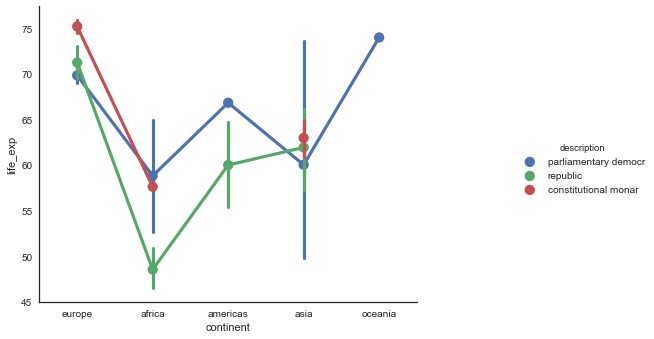

In [47]:
grid = sns.factorplot('continent', 'life_exp', data=data_avg, hue='description')
grid.fig.set_size_inches(10, 5)

## Link to t-tests

Finally - as we mentioned, most of "tradional" statistics are some version of the linear model. For example, below we'll show how fitting a linear model with one categorical variable is the same thing as running a t-test:

In [48]:
data_continent_ols = data_continent.reset_index()
data_continent_ols.head()

,continent,life_exp
0,americas,50.917
1,asia,37.373
2,americas,50.789
3,asia,37.468
4,americas,50.643


In [49]:
stt.ttest_ind(data_continent[continent_1], data_continent[continent_2])

Ttest_indResult(statistic=-2.7663938871382028, pvalue=0.007972057037790475)

In [50]:
lm = sm.formula.ols('life_exp ~ continent', data=data_continent_ols).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.117   
Dependent Variable:  life_exp         AIC:                373.3481
Date:                2017-05-07 10:42 BIC:                377.2118
No. Observations:    51               Log-Likelihood:     -184.67 
Df Model:            1                F-statistic:        7.653   
Df Residuals:        49               Prob (F-statistic): 0.00797 
R-squared:           0.135            Scale:              85.136  
------------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
Intercept         53.2798   1.8454 28.8720 0.0000  49.5714 56.9883
continent[T.asia] -7.1499   2.5845 -2.7664 0.0080 -12.3437 -1.9560
------------------------------------------------------------------
Omnibus:               3.140        Durbin-Watson:           1.604
Prob(Omnibus):         0.208        Jarque-Bera (JB):        1.962
Skew:                  0.252        Prob(JB):                0.375
Kurtosis:              2.182        Condition No.:           3    
==================================================================

"""

Note that the t-value found in the t-test is the same thing as the one found in the `continent[T.asia]` coefficient.